In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
train_data = pd.read_csv('data/train_values.csv', index_col=0, parse_dates=['timestamp'])
train_labels = pd.read_csv('data/train_labels.csv', index_col=0)
test_data = pd.read_csv('data/test_values.csv', index_col=0, parse_dates=['timestamp'])


**Для начала воспользуемся бэнчмарком, данным на соревновании и попытаемся его улучшить:**

*Пропусков в данных практически нет(кроме последнего столбца)*

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5987820 entries, 0 to 5987819
Data columns (total 35 columns):
process_id                    int64
object_id                     int64
phase                         object
timestamp                     datetime64[ns]
pipeline                      object
supply_flow                   float64
supply_pressure               float64
return_temperature            float64
return_conductivity           float64
return_turbidity              float64
return_flow                   float64
supply_pump                   bool
supply_pre_rinse              bool
supply_caustic                bool
return_caustic                bool
supply_acid                   bool
return_acid                   bool
supply_clean_water            bool
return_recovery_water         bool
return_drain                  bool
object_low_level              bool
tank_level_pre_rinse          float64
tank_level_caustic            float64
tank_level_acid               float64
tank

In [4]:
# subset to final rinse phase observations
#train_data.fillna(value=True, inplace=True)
final_phases = train_data[train_data['target_time_period']]
#just one process
final_phase = final_phases[final_phases['process_id'] == 20017]

In [5]:
# calculate target variable
final_phase = final_phase.assign(target=np.maximum(final_phase['return_flow'], 0) * final_phase['return_turbidity'])

In [6]:
final_phase.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period,target
row_id,,,,,,,,,,,,,,,,,,,,,
13835,20017,204,final_rinse,2018-03-05 21:31:35,L2,8926.505,1.439019,53.754340,9.294569,0.383391,...,82.219330,72.276474,45.519928,45.603252,False,0.0,False,0.0,True,1454.634597
13836,20017,204,final_rinse,2018-03-05 21:31:37,L2,9009.693,1.465712,50.857204,8.735830,0.372540,...,82.219330,72.276474,45.518127,45.603252,False,0.0,False,0.0,True,1499.701905
13837,20017,204,final_rinse,2018-03-05 21:31:39,L2,9165.221,1.516927,48.470055,7.943024,0.368924,...,82.197624,72.276474,45.516660,45.603252,False,0.0,False,0.0,True,1682.626857
13838,20017,204,final_rinse,2018-03-05 21:31:41,L2,9252.025,1.560113,45.988860,7.108860,0.372540,...,82.197624,72.276474,45.514927,45.603252,False,0.0,False,0.0,True,1680.258986
13839,20017,204,final_rinse,2018-03-05 21:31:43,L2,9450.955,1.610677,43.645110,6.823575,0.354456,...,82.219330,72.276474,45.516262,45.603252,False,0.0,False,0.0,True,1553.821926


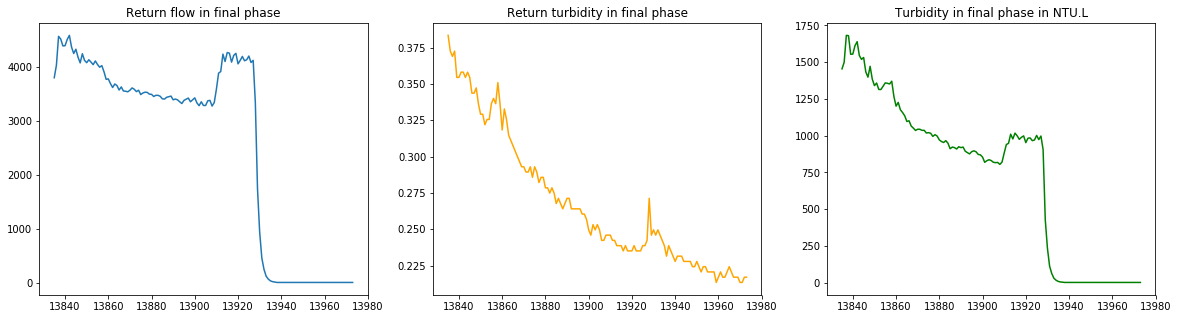

In [7]:
# plot flow, turbidity, and target 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(final_phase['return_flow'])
ax[0].set_title('Return flow in final phase')

ax[1].plot(final_phase['return_turbidity'], c='orange')
ax[1].set_title('Return turbidity in final phase')

ax[2].plot(final_phase['target'], c='green')
ax[2].set_title('Turbidity in final phase in NTU.L');

In [8]:
#sum to get target
final_phase['target'].sum()

103724.28729467509

In [9]:
#confirm that value matches the target label for this process_id
train_labels.loc[20017]

final_rinse_total_turbidity_liter    103724.287295
Name: 20017, dtype: float64

### Удалим из тренировочной выборки записи о последней стадии, так как цель - предсказать помутнение заблаговременно:

In [10]:
train_data = train_data[train_data['phase'] != 'final_rinse']

Text(0.5, 1.0, 'Количество процессов в $N$-й фазе')

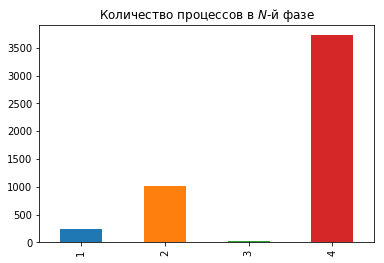

In [11]:
train_data.groupby('process_id')['phase'].nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов в $N$-й фазе")

### Создадим уникальный индентификатор фазы для каждого процесса:


In [12]:
train_data['process_phase'] = train_data.process_id.astype(str) + '_' + train_data.phase.astype(str)
process_phases = train_data.process_phase.unique()

# randomly select 85% of phases to keep
rng = np.random.RandomState(2019)
to_keep = rng.choice(
                process_phases,
                size=np.int(len(process_phases) * 0.85),
                replace=False)

train_limited = train_data[train_data.process_phase.isin(to_keep)]

# subset labels to match our training data
train_labels = train_labels.loc[train_limited.process_id.unique()]

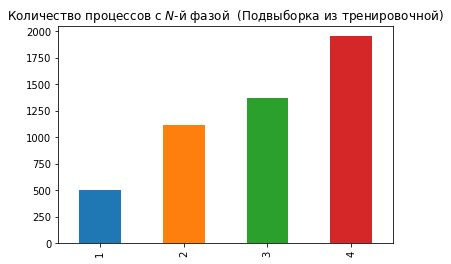

In [13]:
train_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов с $N$-й фазой  (Подвыборка из тренировочной)");

### Feature engineering

In [14]:
def prep_metadata(df):
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data
    if 'L12' not in meta.columns:
        meta['pipeline_L12'] = 0
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# show example for first 5,000 observations
prep_metadata(train_limited.head(5000))

,pipeline_L3,pipeline_L4,pipeline_L7,pipeline_L12,num_phases
process_id,,,,,
20001,0,1,0,0,4
20002,1,0,0,0,2
20003,1,0,0,0,3
20004,0,0,1,0,2
20005,0,0,1,0,1
20008,0,1,0,0,2


In [15]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

In [16]:
# import scipy as sc
def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns
    
    ts_df = df[ts_cols].set_index('process_id')
    
    # create features: min, max, mean, standard deviation, and mean of the last ten observations
    ts_features = ts_df.groupby('process_id').aggregate(['min', 'max', 'mean', 'std',
                                                         lambda x: x.tail(25).mean(),
                                                         'sum', 'mad'])
                                                         

    return ts_features

# show example for first 5,000 observations
prep_time_series_features(train_limited.head(5000), columns=ts_cols)

supply_flow                                                       \
                    min         max          mean           std     <lambda>   
process_id                                                                     
20001         21.701390   59396.703  49501.604051  12445.724586  53491.60912   
20002          7.233796   34295.430  27142.963425   8337.197885  29932.00252   
20003      -1244.213000  103096.070  29902.913654  10872.426632  32634.98240   
20004        -43.402780   49537.035  31117.193119  13046.723480  37233.21852   
20005          0.000000   31295.209  28241.716353   7107.794924  30890.76980   
20008       2723.524400   60980.902  47568.718207  11803.270140  54975.11592   

                                       supply_pressure                      \
                     sum           mad             min       max      mean   
process_id                                                                   
20001       7.053979e+07   8731.408060       -0.036024  2.223741  1.673456   
20002       1.210576e+07   5058.926236       -0.034071  2.170790  1.477925   
20003       5.143301e+07   7421.254958       -0.033854  3.855469  2.630566   
20004       1.160671e+07   9014.189540       -0.009549  0.482422  0.287865   
20005       7.173396e+06   4309.652939       -0.023438  0.487196  0.418469   
20008       3.719874e+07  10394.782334       -0.092665  0.174913  0.169046   

              ...    tank_concentration_caustic                          \
              ...                      <lambda>           sum       mad   
process_id    ...                                                         
20001         ...                     45.917979  64504.937487  0.229367   
20002         ...                     45.346798  20236.779136  0.177727   
20003         ...                     44.853116  77670.170913  0.205475   
20004         ...                     45.245803  16850.889818  0.097955   
20005         ...                     46.041189  11471.652058  0.378942   
20008         ...                     45.079354  35486.974349  0.245106   

           tank_concentration_acid                                             \
                               min        max       mean       std   <lambda>   
process_id                                                                      
20001                    39.447857  52.411568  44.711593  0.648487  44.650637   
20002                    44.216820  44.708210  44.332388  0.079575  44.256440   
20003                    43.750900  45.270653  44.503377  0.236661  44.659532   
20004                    44.154810  45.862520  44.835026  0.485012  45.436548   
20005                    43.527600  44.412254  43.921479  0.249111  43.987345   
20008                    44.621710  45.163643  44.808678  0.065374  44.946055   

                                    
                     sum       mad  
process_id                          
20001       63714.019668  0.364873  
20002       19772.245256  0.059079  
20003       76545.807942  0.203712  
20004       16723.464537  0.457784  
20005       11156.055725  0.219600  
20008       35040.386535  0.054495  

[6 rows x 105 columns]

In [17]:
def create_feature_matrix(df):
    metadata = prep_metadata(df)
    time_series = prep_time_series_features(df)
    
    # join metadata and time series features into a single dataframe
    feature_matrix = pd.concat([metadata, time_series], axis=1)
    
    
    return feature_matrix

In [18]:
train_features = create_feature_matrix(train_limited)

# Строим модели и тестируем их:

**Напишем функцию, которая считает ошибку предсказания. Для того, чтобы её можно было использовать вместе с sklearn воспользуемся sklearn.metrics.make_scorer:**

In [19]:
def mean_abs_percentage_err(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), np.full(np.shape(y_true), 290000)))

from sklearn.metrics import make_scorer
mape_modified_scorer = make_scorer(mean_abs_percentage_err, greater_is_better=False)
    

## Воспользуемся TimeSeriesSplit для проведения кросс-валидации для временных рядом и GridSearchCV, чтобы найти оптимальные параметры для 

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, np.ravel(train_labels),
                                    train_size=0.7, random_state=13)

rf_regressor = RandomForestRegressor(n_estimators=50, random_state=13, n_jobs=-1, max_leaf_nodes=165, 
                                     min_samples_leaf=8, min_samples_split=0.005
#                                     max_depth=23,
#                                    max_leaf_nodes= 100,
#                                     min_samples_leaf = 5,
                                     
      
                                    #max_features=17,
                                   # criterion = 'mse',
                                  
                                    )
rf_param_grid =  {
                  'n_estimators' : [50],
                  'random_state' : [13], 
                  #'n_jobs=-1' : [-1],
                  'max_depth' : [35],
                  'max_features' : [40, 50, 80],
                  'min_weight_fraction_leaf' : [0.5, 0.1, 0.01, 0.0001,  0.00001],
                  'min_impurity_decrease' : [0.00001, 0.001, 0.01, 0.1, 1],
                  'min_impurity_split' : [0.00001, 0.001, 0.01, 0.1, 0.5]
                 # 'min_samples_leaf' : list(np.arange(2, 13)) + [20, 25, 50],
                 # 'max_leaf_nodes' : list(np.arange(2, 13)) + [20, 25, 50]
                                        }                 
rf_grid = GridSearchCV(estimator=rf_regressor, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=rf_param_grid)

#sgd_regr = SGDRegressor(penalty='elasticnet', penalty='l1')

In [52]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 375 candidates, totalling 1875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 1875 out of 1875 | elapsed: 18.7min finished
/home/paniquex/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/paniquex/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value 

/home/paniquex/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/paniquex/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/paniquex/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py:283: DeprecationWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/paniquex/anaconda3/lib/python3.7/site-packages/sklearn/tre

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=165,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=13, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50], 'random_state': [13], 'max_depth': [35], 'max_features': [40, 50, 80], 'min_weight_fraction_leaf': [0.5, 0.1, 0.01, 0.0001, 1e-05], 'min_impurity_decrease': [1e-05, 0.001, 0.01, 0.1, 1], 'min_impurity_split': [1e-05, 0.001, 0.01, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbo

## Оптимальные параметры и лучший результат:

In [21]:
rf_grid.best_params_, rf_grid.best_score_
#
#({'max_depth': 35,
#  'max_features': 40,
#  'min_impurity_decrease': 0.001,
#  'min_impurity_split': 0.001,
#  'min_weight_fraction_leaf': 0.0001,
#  'n_estimators': 50,
#  'random_state': 13},
# -0.6484711766257679)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [38]:
#rf_grid.best_params_, rf_grid.best_score_
#({'max_depth': 20,
#  'max_features': 40,
#  'min_samples_leaf': 5,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6180501020995538)
#{'max_depth': 20,
#  'max_features': 50,
#  'max_leaf_nodes': 50,
#  'min_samples_leaf': 3,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6628379946829989

rf_after_grid = RandomForestRegressor(n_estimators=350, max_depth=35, max_features=70, 
                                      min_samples_leaf=8, max_leaf_nodes = 165, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      bootstrap=False,
                                      random_state=13)
rf_after_grid.fit(X_train, y_train)
#rf_grid.best_params_, rf_grid.best_score_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features=70, max_leaf_nodes=165,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=350, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [22]:
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=2019, verbose=0, warm_start=False)

## Еще проверим нашу модель на отложенной выборке:

In [39]:
mean_abs_percentage_err(rf_after_grid.predict(X_test), y_test) - 0.8716019605033136

0.006958031488263794

In [40]:
rf_after_grid.fit(train_features, np.ravel(train_labels))

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features=70, max_leaf_nodes=165,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=350, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [41]:
test_features = create_feature_matrix(test_data)
preds = rf_after_grid.predict(test_features)

In [42]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [43]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [44]:
my_submission.to_csv('./submissions/4th_try_to_beat_benchmark.csv')

# Попробуем применить линейные модели к прошкалированным данным

In [38]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score


from sklearn.preprocessing import StandardScaler
std_scal = StandardScaler()
for col in train_features.columns:
    train_features[col] = std_scal.fit_transform(train_features[col].values.reshape(-1, 1))
    test_features[col] = std_scal.transform(test_features[col].values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(train_features, np.ravel(train_labels),
                                    train_size=0.7, random_state=13)    



In [39]:
sgd = SGDRegressor( epsilon=500000, loss='huber', validation_fraction=0.2, random_state=13, n_iter=1000)
sgd.fit(X_train, y_train)

/home/paniquex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False,
       epsilon=500000, eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='huber', max_iter=None,
       n_iter=1000, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=13, shuffle=True, tol=None, validation_fraction=0.2,
       verbose=0, warm_start=False)

## Странно, что значения не совпадают. Нужно разобраться.

In [40]:
mape_modified_scorer(sgd, X_test, y_test), mean_abs_percentage_err(sgd.predict(X_test), y_test)

(-1.4203935830799754, 0.7189541952403115)

In [41]:
rf_after_grid.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features=50, max_leaf_nodes=165, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=0.005, min_weight_fraction_leaf=0.0,
           n_estimators=275, n_jobs=None, oob_score=False, random_state=13,
           verbose=0, warm_start=False)

In [42]:
mape_modified_scorer(rf_after_grid, X_test, y_test), mean_abs_percentage_err(rf_after_grid.predict(X_test), y_test)

(-0.532213609214092, 0.9126655282452267)

In [403]:
sgd.fit(train_features, np.ravel(train_labels))

/home/paniquex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='huber', max_iter=None, n_iter=100,
       n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=13,
       shuffle=True, tol=None, validation_fraction=0.2, verbose=0,
       warm_start=False)

In [65]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
ridge_param_grid = {'alpha' : [1.001, 20000, 0.00000001, 0.00001, 0.00004],
                    'tol' : list(0.1 + np.arange(50) / 5000)}
ridge = Ridge(normalize=True, fit_intercept=True, )
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=TimeSeriesSplit(5), 
                         verbose=1, scoring=mape_modified_scorer)
ridge_grid.fit(X_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1250 out of 1250 | elapsed:    5.4s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1.001, 20000, 1e-08, 1e-05, 4e-05], 'tol': [0.1, 0.10020000000000001, 0.1004, 0.10060000000000001, 0.1008, 0.101, 0.10120000000000001, 0.1014, 0.10160000000000001, 0.1018, 0.10200000000000001, 0.1022, 0.1024, 0.10260000000000001, 0.1028, 0.10300000000000001, 0.1032, 0.1034, 0.1...0001, 0.1086, 0.10880000000000001, 0.109, 0.1092, 0.10940000000000001, 0.1096, 0.10980000000000001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbose=1)

In [66]:
ridge_grid.best_params_

{'alpha': 1.001, 'tol': 0.1}

In [67]:
mape_modified_scorer(ridge_grid, X_test, y_test), mean_abs_percentage_err(ridge_grid.predict(X_test), y_test)

(-0.8775350595007269, 2.1444336924634864)

In [56]:
preds = sgd.predict(test_features)

In [57]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [58]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [59]:
my_submission.to_csv('./submissions/4th_try_to_beat_benchmark.csv')

## Хоть и SGD показал отличные результаты на отложенной выборке, но он дает слишком различающиеся значения относительно предыдущих решений. Пока что не буду его использовать

In [60]:
subm_1 = pd.read_csv('./submissions/first_try_to_beat_benchmark.csv', index_col=0)
subm_2 = pd.read_csv('./submissions/third_try_to_beat_benchmark.csv', index_col=0)
np.mean(subm_1['final_rinse_total_turbidity_liter'] - my_submission['final_rinse_total_turbidity_liter'])

710247.208407613

,final_rinse_total_turbidity_liter
count,2.967000e+03
mean,1.887392e+06
std,1.851280e+06
min,1.342262e+05
25%,7.945474e+05
50%,1.380701e+06
75%,2.290656e+06
max,2.516260e+07
